# How to make a CNN
This is a general way to make a CNN in pytorch. The general design was that outlined in the ppt

As you can see, there are a couple free parameters:
* Number of channels
* Kernel 1 size
* Kernel 2 size
* pooling size
* output size



In [1]:
# Lets see what the data looks like:
import torch
import numpy as np
import matplotlib.pyplot as plt
X = torch.load('xdata.pt');
Y = torch.load('ydata.pt');

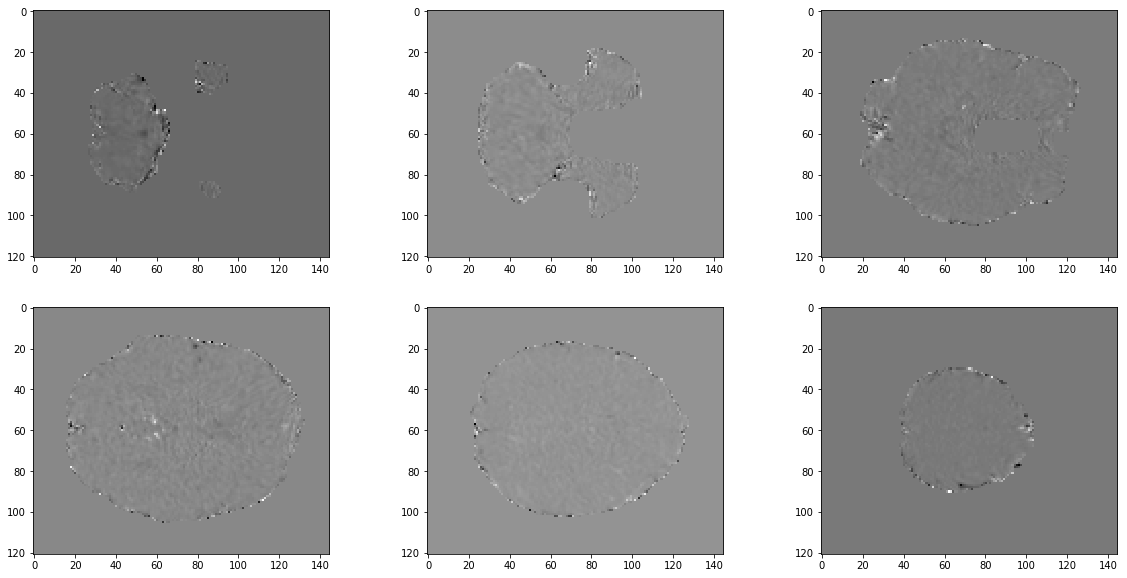

In [3]:
# Lets make a function for plotting
def plotter(imgs):
    fig1 = plt.figure(figsize=(20,10))
    for idx,val in enumerate([20,30,40,50,70,90]):
        ax = fig1.add_subplot(2,3,idx+1)
        ax.imshow(imgs[:,:,val].numpy(),cmap='gray')
plotter(X[10])

In [4]:
class standardCNN(torch.nn.Module):
    def __init__(self, imgSize=[121,145,121],chans=10, k1=5, k2=5, mp=5, fc=100):
        super(standardCNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1,10,k1),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(mp));
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(10,chans,k2),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(mp))
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(360,fc); # I pre-calculated this, but could write a function

    def forward(self, x):
        out = self.layer2(self.layer1(x))
        out = self.linear(self.flatten(out))
        return out

In [5]:
# Write our own function to make *full sized* batches
def batch_generator(length, batch_size):
    indices = np.arange(length); 
    np.random.shuffle(indices); batch=[] 
    for i in indices:
        batch.append(i)
        if len(batch)==batch_size:
            yield batch
            batch=[]

In [12]:
model = standardCNN();
model.to('cuda')
net = torch.nn.DataParallel(model)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.AdamW(net.parameters(),lr=.001)

In [ ]:
globStep=0; batchSize=6;
for epoch in range(5):
    for idx,batch in enumerate(batch_generator(len(X),batchSize)):
        output = net(X[batch].unsqueeze(1).cuda())
        loss = criterion(output, Y[batch].cuda())
        loss.backward(); globStep+=1
        optimizer.step()
        optimizer.zero_grad()
        print('Epoch: ',epoch,'   Num Its: ', globStep*batchSize,'   Loss: ', loss.item())

In [ ]:
# Same function, but now writing to tensorboard!
from torch.utils.tensorboard import SummaryWriter
tboardDir = 'del/' 
writer = SummaryWriter(tboardDir)
globStep=0; batchSize=6;
for epoch in range(5):
    for idx,batch in enumerate(batch_generator(len(X),batchSize)):
        output = net(X[batch].unsqueeze(1).cuda())
        loss = criterion(output, Y[batch].cuda())
        loss.backward(); globStep+=1
        optimizer.step()
        optimizer.zero_grad()
        writer.add_scalars('loss',{'trainL':loss.item()},global_step=globStep*batchSize)